# Arthur Sandbox Example: Comparing LLMs


We will be comparing three different LLM endpoints - Cohere's XLarge and OpenAI's GPT3 and ChatGPT - on a set of scientific question-answering unit tests.

We will onboard these endpoints as models to Arthur with the different attributes available at each endpoint.

We will then compare the models based on how often they correctly answered the unit tests, the readability of each generation according to the Flesch Readability Index, and use ChatGPT itself to provide written and numerical evaluation for the inferences.

---

# Setup & Imports

In [1]:
# ensure required packages are installed
#  don't worry, our requirements are flexible!

! pip install -r requirements.txt > /dev/null

In [2]:
from datetime import datetime, timedelta
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import shortuuid

In [3]:
import cohere
import openai
co = cohere.Client('<your cohere api key here>')

---

# Onboarding

## Loading the Dataset

We're using the [SciQ dataset from Huggingface](https://huggingface.co/datasets/sciq)

The SciQ dataset contains 13,679 crowdsourced science exam questions about Physics, Chemistry and Biology, among others. The questions are in multiple-choice format with 4 answer options each. For the majority of the questions, an additional paragraph with supporting evidence for the correct answer is provided.

In [3]:
from datasets import load_dataset

In [4]:
sciq_dataset = load_dataset("sciq")

Found cached dataset sciq (/Users/maxcembalest/.cache/huggingface/datasets/sciq/default/0.1.0/50e5c6e3795b55463819d399ec417bfd4c3c621105e00295ddb5f3633d708493)


  0%|          | 0/3 [00:00<?, ?it/s]

We will split the data into a reference set for our model and a inference set to represent deployment inferences

In [591]:
sciq_df_train = sciq_dataset.data['train'].table.to_pandas()
sciq_df_test = sciq_dataset.data['test'].table.to_pandas()

In [592]:
sciq_df_ref = sciq_df_train.sample(50)
sciq_df_inf = sciq_df_test.sample(50)

## Create the full LLM input strings by concatenating the actual question after a sentence/paragraph of supporting information

In [593]:
input_strings_ref = [
    f"What is the answer to this question? question: {row.question}, answer: " 
    for _, row in sciq_df_ref.iterrows()
]
input_strings_inf = [
    f"What is the answer to this question? question: {row.question}, answer: " 
    for _, row in sciq_df_inf.iterrows()
]

# Get LLM responses

In [594]:
import openai
import textstat
from typing import List, Tuple

def get_cohere_responses(inputs: List[str]):
    """
    Applies Cohere to the inputs
    """
    
    cohere_responses = []

    for inp in inputs:
        cohere_response = co.generate(
            prompt=inp,
            max_tokens=25,
            return_likelihoods="GENERATION"
        )
        cohere_answer = cohere_response.generations[0].text
        cohere_responses.append(cohere_response)
    return cohere_responses

def get_gpt3_responses(inputs: List[str]):
    """
    Applies GPT3 to the inputs
    """
    
    responses = []
    
    for inp in inputs:
        openai_response = openai.Completion.create(
            model="text-davinci-003", 
            prompt=inp, 
            temperature=0.1, 
            logprobs=1)
        gpt3_answer = openai_response["choices"][0]["text"]
        responses.append(openai_response)
    
    return responses

def get_chatgpt_responses(
    inputs: List[str],
    system_config: str = "You answer scientific questions about physics, biology, and chemistry.",
    example_behavior: Tuple[str, str] = ("What is the difference between xylem and phloem?", "Xylem transports and stores water and water-soluble nutrients in vascular plants. Phloem is responsible for transporting sugars, proteins, and other organic molecules in plants. Vascular plants are able to grow higher than other plants due to the rigidity of xylem cells, which support the plant.")
):
    """
    Applies ChatGPT to the inputs
    We manually write a config setting ("system" message) and an example back-and-forth ("user" and "assistant" messages)
    """
    responses = []
    for inp in inputs:
        messages = [
            {"role": "system", "content": system_config},
            {"role": "user", "content": example_behavior[0]},
            {"role": "assistant", "content": example_behavior[1]},
            {"role": "user", "content": inp}
        ]

        openai_response = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages=messages
        )
        chat_gpt_answer = openai_response["choices"][0]["message"]["content"]
        responses.append(openai_response)
    
    return responses
    

In [4]:
cohere_responses_ref = get_cohere_responses(input_strings_ref)
gpt3_responses_ref = get_gpt3_responses(input_strings_ref)
chatgpt_responses_ref = get_chatgpt_responses(input_strings_ref)
cohere_responses_inf = get_cohere_responses(input_strings_inf)
gpt3_responses_inf = get_gpt3_responses(input_strings_inf)
chatgpt_responses_inf = get_chatgpt_responses(input_strings_inf)

In [596]:
cohere_response_texts_ref = [c.generations[0].text for c in cohere_responses_ref]
gpt3_response_texts_ref = [c['choices'][0]['text'] for c in gpt3_responses_ref]
chatgpt_response_texts_ref = [c['choices'][0]['message']['content'] for c in chatgpt_responses_ref]
cohere_response_texts_inf = [c.generations[0].text for c in cohere_responses_inf]
gpt3_response_texts_inf = [c['choices'][0]['text'] for c in gpt3_responses_inf]
chatgpt_response_texts_inf = [c['choices'][0]['message']['content'] for c in chatgpt_responses_inf]

### Get token likelihoods

In [597]:
cohere_tokens_ref = [[x.token for x in resp[0].token_likelihoods] for resp in cohere_responses_ref]
cohere_probabilities_ref = [
    list(np.exp([
        x.likelihood 
        for x in resp[0].token_likelihoods]))
    for resp in cohere_responses_ref]
cohere_token_likelihoods_ref = [[
    {t: p} 
    for t, p in zip(cohere_tokens_ref[i], cohere_probabilities_ref[i])] for i in range(len(input_strings_ref))]

gpt3_tokens_ref = [resp['choices'][0]['logprobs']['tokens'] for resp in gpt3_responses_ref]
gpt3_probabilities_ref = [list(np.exp(resp['choices'][0]['logprobs']['token_logprobs'])) for resp in gpt3_responses_ref]
gpt3_token_likelihoods_ref = [[
    {t: p}
    for t, p in zip(gpt3_tokens_ref[i], gpt3_probabilities_ref[i])] for i in range(len(input_strings_ref))]


cohere_tokens_inf = [[x.token for x in resp[0].token_likelihoods] for resp in cohere_responses_inf]
cohere_probabilities_inf = [
    list(np.exp([
        x.likelihood 
        for x in resp[0].token_likelihoods]))
    for resp in cohere_responses_inf]
cohere_token_likelihoods_inf = [[
    {t: p} 
    for t, p in zip(cohere_tokens_inf[i], cohere_probabilities_inf[i])] for i in range(len(input_strings_inf))]

gpt3_tokens_inf = [resp['choices'][0]['logprobs']['tokens'] for resp in gpt3_responses_inf]
gpt3_probabilities_inf = [list(np.exp(resp['choices'][0]['logprobs']['token_logprobs'])) for resp in gpt3_responses_inf]
gpt3_token_likelihoods_inf = [[
    {t: p}
    for t, p in zip(gpt3_tokens_inf[i], gpt3_probabilities_inf[i])] for i in range(len(input_strings_inf))]


### Get finish reasons

In [598]:
gpt3_response_finish_reasons_ref = [c['choices'][0]['finish_reason'] for c in gpt3_responses_ref]
chatgpt_response_finish_reasons_ref = [c['choices'][0]['finish_reason'] for c in chatgpt_responses_ref]
gpt3_response_finish_reasons_inf = [c['choices'][0]['finish_reason'] for c in gpt3_responses_inf]
chatgpt_response_finish_reasons_inf = [c['choices'][0]['finish_reason'] for c in chatgpt_responses_inf]

### Get readability scores

In [599]:
def get_readability(outputs):
    return [textstat.flesch_reading_ease(o) for o in outputs]

In [600]:
cohere_readability_ref = get_readability(cohere_response_texts_ref)
gpt3_readability_ref = get_readability(gpt3_response_texts_ref)
chatgpt_readability_ref = get_readability(chatgpt_response_texts_ref)
cohere_readability_inf = get_readability(cohere_response_texts_inf)
gpt3_readability_inf = get_readability(gpt3_response_texts_inf)
chatgpt_readability_inf = get_readability(chatgpt_response_texts_inf)

### Get correctness for responses

In [601]:
def get_correctness(outputs, answers):
    correctnesses = []
    for a, o in zip(answers, outputs):
        in_ = True
        for word in a.replace(',','').split():
            if word.lower() not in o.lower():
                in_=False
        correctnesses.append(in_)
    return correctnesses

In [602]:
cohere_correctness_ref = get_correctness(
    [c.generations[0].text for c in cohere_responses_ref],
    list(sciq_df_ref.correct_answer.values)
)

gpt3_correctness_ref = get_correctness(
    [c['choices'][0]['text'] for c in gpt3_responses_ref],
    list(sciq_df_ref.correct_answer.values)
)

chatgpt_correctness_ref = get_correctness(
    [c['choices'][0]['message']['content'] for c in chatgpt_responses_ref],
    list(sciq_df_ref.correct_answer.values)
)
cohere_correctness_inf = get_correctness(
    [c.generations[0].text for c in cohere_responses_inf],
    list(sciq_df_inf.correct_answer.values)
)

gpt3_correctness_inf = get_correctness(
    [c['choices'][0]['text'] for c in gpt3_responses_inf],
    list(sciq_df_inf.correct_answer.values)
)

chatgpt_correctness_inf = get_correctness(
    [c['choices'][0]['message']['content'] for c in chatgpt_responses_inf],
    list(sciq_df_inf.correct_answer.values)
)

### Use ChatGPT itself to give written and numeric evaluation to the LLM responses  

In [603]:
def get_pseudofeedback(inputs: List[str]):
    responses = []
    for inp in inputs:
        print(inp)
        messages = [
            {"role": "system", "content": "You give short written feedback saying if an answer made sense for a given question. You also rate the answer out of 10 (0=worst,10=best)"},
            {"role": "user", "content": "What is the answer to this question? question: What makes breathing difficult due to respiratory system disease?, answer: The answer to this question is the answer to your question.\n\nIt is important to know the answer to this question because"},
            {"role": "assistant", "content": "You didn't actually answer the question, thats bad and confusing. 1"},
            {"role": "user", "content": "What is the answer to this question? question: What makes breathing difficult due to respiratory system disease?, answer: Respiratory system diseases can make breathing difficult by causing inflammation, damage, or blockages in the airways or lung tissues. These can include conditions such as asthma, chronic obstructive pulmonary disease (COPD), pneumonia, lung cancer, and others. The inflammation and swelling can narrow the airways, making it harder for air to flow in and out of the lungs. Damage to the lung tissues can reduce their ability to expand and contract, which can also make breathing difficult. Additionally, excess mucus or fluid in the lungs can further narrow the airways and make it hard to breathe. These factors can cause symptoms such as shortness of breath, coughing, wheezing, and fatigue."},
            {"role": "assistant", "content": "Thank you very much, that makes a lot of sense! 10"},
            {"role": "user", "content": inp}
        ]

        openai_response = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages=messages
        )
        chat_gpt_answer = openai_response["choices"][0]["message"]["content"]
        print(chat_gpt_answer, "\n=====\n")
        responses.append(openai_response)
    
    return responses

In [604]:
cohere_pseudofeedback_ref = get_pseudofeedback([inp + rt for inp, rt in zip(input_strings_ref, cohere_response_texts_ref)])
gpt3_pseudofeedback_ref = get_pseudofeedback([inp + rt for inp, rt in zip(input_strings_ref, gpt3_response_texts_ref)])
chatgpt_pseudofeedback_ref = get_pseudofeedback([inp + rt for inp, rt in zip(input_strings_ref, chatgpt_response_texts_ref)])
cohere_pseudofeedback_inf = get_pseudofeedback([inp + rt for inp, rt in zip(input_strings_inf, cohere_response_texts_inf)])
gpt3_pseudofeedback_inf = get_pseudofeedback([inp + rt for inp, rt in zip(input_strings_inf, gpt3_response_texts_inf)])
chatgpt_pseudofeedback_inf = get_pseudofeedback([inp + rt for inp, rt in zip(input_strings_inf, chatgpt_response_texts_inf)])


What is the answer to this question? question: What is a random change in an organism's genes?, answer: The answer to this question is a random mutation.

It's a random mutation that causes a change in the genes of
the organism. That answer makes sense. 8. 
=====

What is the answer to this question? question: What specific part of the brain regulates the endocrine system?, answer: The hypothalamus., question: What does the hypothalamus regulate? answer: The hypothalamus regulates
The answer provided is incomplete and does not finish answering the question. It would be better to include a complete answer. 3 
=====

What is the answer to this question? question: Viruses depend on what type of cells?, answer: Viruses depend on animal cells to survive.

Viruses depend on what type of cells? Viruses depend on
animal cells to survive. The answer you provided is correct and makes sense. 10. 
=====

What is the answer to this question? question: What is the breakdown of unstable elements into

makes sense to be measured by the amplitude of the sound wave, as amplitude determines the amount of energy carried by the wave. Therefore, a higher amplitude corresponds to a more intense sound wave. Good answer! 9 
=====

What is the answer to this question? question: What are hot fragments of rock called?, answer: Igneous rocks are formed when magma cools and solidifies.

Lava is molten rock that has been
The answer given is not relevant and does not address the question asked. The correct answer to the question "What are hot fragments of rock called?" is "Hot fragments of rock are called volcanic fragments or pyroclasts." Therefore, the given answer is not satisfactory. 3. 
=====

What is the answer to this question? question: Which nerve directly stimulates the contraction of skeletal muscles in the pharynx and larynx to contribute to the swallowing and speech functions?, answer: Nerve: Vagus nerve, function: swallowing, speech functions., comment: The vagus nerve is the nerve tha

I'm sorry, but the answer seems incomplete. Could you please provide the complete answer to the question? 
=====

What is the answer to this question? question: Dividing net force by total mass yields what?, answer: acceleration.

Explanation: If you apply a net force on an object, the object will accelerate. The acceleration
of the object depends on the magnitude of the net force and the mass of the object. Dividing the net force by the total mass of the object will give you the acceleration of the object. Therefore, your answer is correct. 10. 
=====

What is the answer to this question? question: Light bends when it passes in from what to what?, answer: Air to glass, glass to water, water to air, question: Light bends when it passes in from what to what
Your answer is correct. Good job! 10 
=====

What is the answer to this question? question: What are the cells that break down inorganic molecules to supply energy for the cell, and use carbon dioxide as a carbon source?, answer: The

Great job! Your answer is correct, neutrons were used to bombard uranium-235 atoms to cause the first reported nuclear fission in 1939. 10 
=====

What is the answer to this question? question: Group 16 is called what?, answer: 

Group 16 is called the Chalcogens.
Great job! Your answer is correct and makes sense. 10 
=====

What is the answer to this question? question: At high pressures, how are the molecules of a gas crowded?, answer: 

At high pressures, the molecules of a gas are crowded together and move
more rapidly in all directions, colliding with each other and with the walls of the container they are in. This causes the gas to become more dense, reducing the space between molecules and increasing the pressure of the gas. So, your answer is incomplete and does not give a clear explanation, 5. 
=====

What is the answer to this question? question: What occurs when the amount of solute dissolved exceeds the solubility of the solute?, answer: 

The solute will precipitate out of

Thank you for your answer, that makes sense. 9 
=====

What is the answer to this question? question: Light bends when it passes in from what to what?, answer:  Light bends when it passes from one medium to another.
Your answer is correct and concise, good job! 9 
=====

What is the answer to this question? question: What are the cells that break down inorganic molecules to supply energy for the cell, and use carbon dioxide as a carbon source?, answer: 

Autotrophic bacteria.
I'm sorry, but that answer doesn't seem to be correct for the given question. The correct answer to the question would be chemotrophic bacteria or chemolithotrophs, since they breakdown inorganic molecules to obtain energy and use CO2 as a carbon source. Autotrophs can also use CO2 as a carbon source but they produce their own organic compounds using external energy sources. I would rate the answer 2 out of 10. 
=====

What is the answer to this question? question: Each enzyme has an optimal what at which its reac

That is a very clear and accurate answer. 10 
=====

What is the answer to this question? question: What vessels supply blood to the myocardium and other components of the heart?, answer: The vessels that supply blood to the myocardium and other components of the heart are the coronary arteries.
Thank you for your answer, it is correct and concise. 10. 
=====

What is the answer to this question? question: The first reported nuclear fission occurred in 1939 when three german scientists bombarded uranium-235 atoms with slow-moving what?, answer: The first reported nuclear fission occurred in 1939 when three German scientists bombarded uranium-235 atoms with slow-moving neutrons.
Great job, your answer is accurate and makes sense. 10 
=====

What is the answer to this question? question: Group 16 is called what?, answer: Group 16 is called the chalcogens. Chalcogens are the elements in Group 16 of the periodic table, including oxygen, sulfur, selenium, tellurium, and polonium.
Yes, that 

Great answer! It makes perfect sense and directly answers the question. 10 
=====

What is the answer to this question? question: Materials that are good conductors of thermal energy are called?, answer: The answer is "Materials that are good conductors of thermal energy are called thermal conductors."
Thank you for the answer. That makes sense. 8 
=====

What is the answer to this question? question: Respectively, which parts of the circulatory system carry blood from the heart toward capillaries, and return blood to the heart from capillaries?, answer: The parts of the circulatory system that carry blood from the heart towards capillaries are arteries. The parts that return blood to the heart from the capillaries are veins.
Great job, that answer makes sense and directly answers the question! 10 
=====

What is the answer to this question? question: What element makes up the majority of coal?, answer: The element that makes up the majority of coal is carbon.
Great, that is a correct 

confusion because they don't have anything under their surface that heats up directly. Instead, they have a series of magnetic coils that generate an electromagnetic field. When you place a magnetic pot or pan on the cooktop, the field induces an electrical current in the metal, which creates heat and cooks the food. Therefore, the correct answer is that induction cooktops have magnetic coils under their surface. The statement "they do not have anything under their surface" is incorrect. I'd rate the answer 4 out of 10. 
=====

What is the answer to this question? question: Reactants may also be present in such low concentrations that it is unlikely they will meet and do what?, answer: react,

A solution is prepared by dissolving 0.10 mole of barium chloride in enough water to
Your answer is not related to the question asked, hence it doesn't make sense. 2 
=====

What is the answer to this question? question: Both the forward reaction and the reverse reaction continue to occur, so che

and a graphic scale. 

I think your answer is incorrect as you only provided one type of map that reveals the shape of a landscape. Therefore, I would rate your answer as 3 out of 10. 
=====

What is the answer to this question? question: Animals with better fitness have a better chance of passing their genes onto the next generation, this process is known as?, answer: natural selection

7. How does this effect change over time? question: How does the variation in traits within a population
You didn't finish the question so it's hard to provide feedback. Please let me know the complete question. 
=====

What is the answer to this question? question: What force occurs because no surface is perfectly smooth?, answer: The force that occurs because no surface is perfectly smooth is called friction. The force that occurs because no surface is perfectly smooth is
The answer is incomplete and redundant. The first sentence is correct, but the second sentence does not provide additional informa

Your first answer is correct, the process is called fluorescence.

The second answer would be "a family or a group". Elements in the same group or family have similar chemical properties because they have the same number of electrons in their outermost energy level, which determines how they react with other elements. So, elements in the same group tend to form similar chemical compounds and have similar physical and chemical properties. 
=====

What is the answer to this question? question: Animals are classified according to morphological and developmental characteristics, such as a body plan. with the exception of sponges, the animal body plan is symmetrical. this means that their distribution of body parts is balanced along this?, answer: midline.

What is the difference between invertebrates and vertebrates? Invertebrates are animals
The answer doesn't seem to be complete and doesn't make sense as it doesn't answer the question asked. For the second question, the answer seems inco

That answer makes sense for the question asked. 9 
=====

What is the answer to this question? question: What do induction cooktops have under their surface?, answer: 

Induction cooktops have an electromagnetic coil under their surface.
Thank you for the clear and concise answer, that makes sense. 9 
=====

What is the answer to this question? question: Reactants may also be present in such low concentrations that it is unlikely they will meet and do what?, answer:  react
The answer to the question is incomplete and unclear. It's not clear what the reactants are reacting with or what they are reacting to. The answer needs to be more specific and provide additional information. 2.5 
=====

What is the answer to this question? question: Both the forward reaction and the reverse reaction continue to occur, so chemical equilibrium is said to be what, rather than static?, answer:  dynamic
Yes, that is correct! Your answer makes complete sense. 10 
=====

What is the answer to this question

Your answer is correct and to the point. 10 
=====

What is the answer to this question? question: Movements in the mantle cause the plates to move over time in a process called what?, answer:  Plate Tectonics
Your answer is correct and makes sense! 10 
=====

What is the answer to this question? question: Ac is better than dc for doing what?, answer: 

AC is better than DC for transmitting power over long distances.
Thank you for your answer! It is correct and to the point. 10. 
=====

What is the answer to this question? question: What is the process of filtering waste from the kidneys?, answer: 

The process of filtering waste from the kidneys is called renal filtration
Sorry, your answer is incorrect. While "renal filtration" is a term related to the process, it doesn't explain the actual process itself. The process of filtering waste from the kidneys involves three main steps: glomerular filtration, tubular reabsorption, and tubular secretion. Glomerular filtration is the process 

Thank you for your answer. That makes sense. 8 
=====

What is the answer to this question? question: Fungi often make specialized reproductive structures, such as what?, answer: Fungi often make specialized reproductive structures, such as spores, mushrooms, and fruiting bodies.
Thank you for your answer, that makes sense. 9 
=====

What is the answer to this question? question: What kind of weather can you expect if a center of low pressure is moving your way?, answer: If a center of low pressure is moving towards a location, it typically indicates that the weather may change and become more unsettled. This can often result in cloudy or rainy conditions, as the low-pressure system can create instability in the atmosphere, which can lead to the formation of storms, precipitation, and other forms of precipitation. Additionally, low-pressure systems can also cause changes in temperature and wind conditions, so it's important to monitor weather forecasts closely if a low-pressure system 

Great job! Your answer is clear and accurate. 10 
=====

What is the answer to this question? question: What acids are the structural components of many lipids and may be saturated or unsaturated?, answer: Fatty acids are the structural components of many lipids and may be saturated or unsaturated.
Great answer! It is clear and concise. 10 
=====

What is the answer to this question? question: What type of map reveals the shape of a landscape?, answer: The answer to the question is a topographic map. A topographic map reveals the shape, contours, and elevations of a landscape or terrain, showing the physical features like mountains, valleys, rivers, and other land formations.
Great answer, that makes perfect sense! 10 
=====

What is the answer to this question? question: Animals with better fitness have a better chance of passing their genes onto the next generation, this process is known as?, answer: Natural selection.
Great answer! That makes sense. 10. 
=====

What is the answer to

Excellent explanation, it makes perfect sense. 10 
=====

What is the answer to this question? question: The amniotic egg is a shared ancestral character for which clade?, answer: The amniotic egg is a shared ancestral character for the clade Amniotes. The Amniotes include reptiles, birds, and mammals, which all evolved from a common ancestor that had a terrestrial lifestyle and a shelled egg that could be laid on land.
Yes, your answer is correct and provides a comprehensive explanation. 10 
=====

What is the answer to this question? question: What term always refers to acceleration in the direction opposite to the direction of the velocity and always reduces speed, unlike negative acceleration?, answer: The answer is "deceleration".
Yes, that is correct and it makes sense. 10. 
=====

What is the answer to this question? question: What are biochemical catalysts that speed up biochemical reactions?, answer: The answer to the question "What are biochemical catalysts that speed up bioc

In [605]:
def get_feedback_scores(feedback_strings):
    feedback_ints = []
    for fs in feedback_strings:
        score = -1
        fs = fs.replace('out of 10', '')
        for num_string in np.arange(11).astype(str):
            if num_string in fs:
                score = int(num_string)
        feedback_ints.append(score)
    return feedback_ints

In [608]:
cohere_pseudofeedback_messages_ref = [c['choices'][0]['message']['content'] for c in cohere_pseudofeedback_ref]
gpt3_pseudofeedback_messages_ref = [c['choices'][0]['message']['content'] for c in gpt3_pseudofeedback_ref]
chatgpt_pseudofeedback_messages_ref = [c['choices'][0]['message']['content'] for c in chatgpt_pseudofeedback_ref]
cohere_pseudofeedback_messages_inf = [c['choices'][0]['message']['content'] for c in cohere_pseudofeedback_inf]
gpt3_pseudofeedback_messages_inf = [c['choices'][0]['message']['content'] for c in gpt3_pseudofeedback_inf]
chatgpt_pseudofeedback_messages_inf = [c['choices'][0]['message']['content'] for c in chatgpt_pseudofeedback_inf]

In [609]:
cohere_feedback_scores_ref = get_feedback_scores(cohere_pseudofeedback_messages_ref)
gpt3_feedback_scores_ref = get_feedback_scores(gpt3_pseudofeedback_messages_ref)
chatgpt_feedback_scores_ref = get_feedback_scores(chatgpt_pseudofeedback_messages_ref)

cohere_feedback_scores_inf = get_feedback_scores(cohere_pseudofeedback_messages_inf)
gpt3_feedback_scores_inf = get_feedback_scores(gpt3_pseudofeedback_messages_inf)
chatgpt_feedback_scores_inf = get_feedback_scores(chatgpt_pseudofeedback_messages_inf)

### Create inference dataframes

In [610]:
cohere_ref_data = pd.DataFrame({
    'user_input':input_strings_ref,
    'output_text':cohere_response_texts_ref,
    'token_likelihoods':cohere_token_likelihoods_ref,
    'readability':cohere_readability_ref,
    'correct':cohere_correctness_ref,
    'user_feedback':cohere_pseudofeedback_messages_ref,
    'user_feedback_score':cohere_feedback_scores_ref,
})

gpt3_ref_data = pd.DataFrame({
    'user_input':input_strings_ref,
    'output_text':gpt3_response_texts_ref,
    'token_likelihoods':gpt3_token_likelihoods_ref,
    'finish_reason':gpt3_response_finish_reasons_ref,
    'readability':gpt3_readability_ref,
    'correct':gpt3_correctness_ref,
    'user_feedback':gpt3_pseudofeedback_messages_ref,
    'user_feedback_score':gpt3_feedback_scores_ref,
})

chatgpt_ref_data = pd.DataFrame({
    'user_input':input_strings_ref,
    'output_text':chatgpt_response_texts_ref,
    'finish_reason':chatgpt_response_finish_reasons_ref,
    'readability':chatgpt_readability_ref,
    'correct':chatgpt_correctness_ref,
    'user_feedback':pseudofeedback_messages_ref,
    'user_feedback_score':chatgpt_feedback_scores_ref,
})

cohere_inf_data = pd.DataFrame({
    'user_input':input_strings_inf,
    'output_text':cohere_response_texts_inf,
    'finish_reason':cohere_token_likelihoods_inf,
    'readability':cohere_readability_inf,
    'correct':cohere_correctness_inf,
    'user_feedback':cohere_pseudofeedback_messages_inf,
    'user_feedback_score':cohere_feedback_scores_inf,
})

gpt3_inf_data = pd.DataFrame({
    'user_input':input_strings_inf,
    'output_text':gpt3_response_texts_inf,
    'token_likelihoods':gpt3_token_likelihoods_inf,
    'finish_reason':gpt3_response_finish_reasons_inf,
    'readability':gpt3_readability_inf,
    'correct':gpt3_correctness_inf,
    'user_feedback':gpt3_pseudofeedback_messages_inf,
    'user_feedback_score':gpt3_feedback_scores_inf,
})

chatgpt_inf_data = pd.DataFrame({
    'user_input':input_strings_inf,
    'output_text':chatgpt_response_texts_inf,
    'finish_reason':chatgpt_response_finish_reasons_inf,
    'readability':chatgpt_readability_inf,
    'correct':chatgpt_correctness_inf,
    'user_feedback':chatgpt_pseudofeedback_messages_inf,
    'user_feedback_score':chatgpt_feedback_scores_inf,
})

In [639]:
cohere_ref_data

,user_input,output_text,token_likelihoods,readability,correct,user_feedback,user_feedback_score
0,What is the answer to this question? question:...,The answer to this question is a random mutati...,"[{' The': 0.2125266896822057}, {' answer': 0.5...",77.74,True,the organism. That answer makes sense. 8.,8
1,What is the answer to this question? question:...,"The hypothalamus., question: What does the hyp...","[{' The': 0.587550058873798}, {' hyp': 0.49867...",-10.76,True,The answer provided is incomplete and does not...,3
2,What is the answer to this question? question:...,Viruses depend on animal cells to survive.\n\n...,"[{' Virus': 0.12121889720109613}, {'es': 0.982...",74.15,False,animal cells to survive. The answer you provid...,10
3,What is the answer to this question? question:...,The natural process by which unstable elements...,"[{' The': 0.07115262935743544}, {' natural': 0...",60.31,True,That answer makes sense and directly answers t...,10
4,What is the answer to this question? question:...,Hydroids belong to the Cnidaria. There are two...,"[{' Hydro': 0.03992918375556969}, {'ids': 0.27...",81.80,False,This answer does not address the question. It ...,2
5,What is the answer to this question? question:...,The leading cause of lung cancer is smoking.\n...,"[{' The': 0.16808104587187545}, {' leading': 0...",81.59,False,"Yes, the answer you provided makes complete se...",10
6,What is the answer to this question? question:...,stamen\n\nThe answer to this question: A famil...,"[{' st': 0.17310100689100383}, {'amen': 0.9183...",53.21,True,This answer does not make sense for the given ...,2
7,What is the answer to this question? question:...,"reaction rates, question: What do all enzymes ...","[{' reaction': 0.03310988171218624}, {' rates'...",61.83,True,The answer to the first question is correct. T...,-1
8,What is the answer to this question? question:...,the solute dissolves into the solvent is calle...,"[{' the': 0.024337989390277825}, {' sol': 0.46...",79.26,False,"The answer to the question ""When a solute diss...",10
9,What is the answer to this question? question:...,"osteoid, explanation: Osteoblasts form osteoid...","[{' oste': 0.13508609001169952}, {'oid': 0.818...",49.82,False,Thank you for your answer! Your explanation is...,9


In [614]:
# cohere_ref_data.to_csv('cohere_reference_data.csv')
# gpt3_ref_data.to_csv('gpt3_reference_data.csv')
# chatgpt_ref_data.to_csv('chatgpt_reference_data.csv')
# cohere_inf_data.to_csv('cohere_inference_data.csv')
# gpt3_inf_data.to_csv('gpt3_inference_data.csv')
# chatgpt_inf_data.to_csv('chatgpt_inference_data.csv')

## Registering Models With Arthur

### Setting Up Connection
Supply your login to authenticate with the platform.

In [618]:
from arthurai import ArthurAI
# connect to Arthur
# UNCOMMENT the two lines below and enter your details
arthur = ArthurAI(
    url="https://app.arthur.ai",  # you can also pass this through the ARTHUR_ENDPOINT_URL environment variable
    login="<your login here>",  # you can also pass this through the ARTHUR_LOGIN environment variable
)

Please enter password for admin: ········


In [619]:
from arthurai.common.constants import ValueType, Stage, InputType, OutputType

### Building the models according to the attributes available at each endpoint

We use a helper function to register the model attributes for the input text each model will process and the different kinds of response data available from each different LLM endpoint.

The Cohere endpoint returns outputs with token likelihoods, ChatGPT returns outputs with stop reasons, and GPT3 returns outputs with both token likelihoods and stop reasons.

#### Cohere

In [622]:
# register arthur model type
arthur_model_cohere = arthur.model(
    display_name="Cohere",
    input_type=InputType.NLP, 
    output_type=OutputType.TokenSequence)

# register attributes for token sequence model
arthur_model_cohere.build_token_sequence_model(
    input_column="user_input", 
    output_text_column="output_text",
    output_likelihood_column="token_likelihoods"
)

arthur_model_cohere.add_attribute(
    name="readability",
    stage=Stage.NonInputData,
    value_type=ValueType.Float,
    min_range=0,
    max_range=100
)

arthur_model_cohere.add_attribute(
    name="correct",
    stage=Stage.NonInputData,
    value_type=ValueType.Boolean,
    categorical=True,
    categories=[True,False]
)

arthur_model_cohere.add_attribute(
    name="user_feedback",
    stage=Stage.NonInputData,
    value_type=ValueType.String,
    categorical=True,
    is_unique=True
)

arthur_model_cohere.add_attribute(
    name="user_feedback_score",
    stage=Stage.NonInputData,
    value_type=ValueType.Integer,
    categorical=True,
    categories=[-1,0,1,2,3,4,5,6,7,8,9,10]
)

arthur_model_cohere.review()

,name,stage,value_type,categorical,is_unique,categories,bins,range,monitor_for_bias
0,user_input,PIPELINE_INPUT,UNSTRUCTURED_TEXT,True,True,[],None,"[None, None]",False
1,token_likelihoods,PREDICTED_VALUE,TOKEN_LIKELIHOODS,False,False,[],None,"[None, None]",False
2,output_text,PREDICTED_VALUE,UNSTRUCTURED_TEXT,True,False,[],None,"[None, None]",False
3,readability,NON_INPUT_DATA,FLOAT,False,False,[],None,"[0, 100]",False
4,correct,NON_INPUT_DATA,BOOLEAN,True,False,"[{value: True}, {value: False}]",None,"[None, None]",False
5,user_feedback,NON_INPUT_DATA,STRING,True,True,[],None,"[None, None]",False
6,user_feedback_score,NON_INPUT_DATA,INTEGER,True,False,"[{value: -1}, {value: 0}, {value: 1}, {value: ...",None,"[None, None]",False


In [623]:
arthur_model_cohere.save()

12:41:07 - arthurai - We have registered the  model with Arthur and are getting it ready to accept inferences...
12:41:52 - arthurai - Model Creation Completed successfully, you can now send Data to Arthur.


'9287ec46-176d-48ef-bc75-03f514b79bc3'

In [640]:
arthur_model_cohere.set_reference_data(data=cohere_ref_data['user_input'])

13:13:14 - arthurai - Starting upload (0.005 MB in 1 files), depending on data size this may take a few minutes
13:13:14 - arthurai - Upload completed: /var/folders/8v/8v36mrp907z7lp5d4cd7yf4h0000gn/T/tmpswnr7bj3/9287ec46-176d-48ef-bc75-03f514b79bc3-0.parquet


({'counts': {'success': 50, 'failure': 0, 'total': 50}, 'failures': [[]]},
 {'dataset_close_result': {'message': 'success'}})

#### GPT3

In [624]:
# register arthur model type
arthur_model_gpt3 = arthur.model(
    display_name="OpenAI_GPT3",
    input_type=InputType.NLP, 
    output_type=OutputType.TokenSequence)

# register attributes for token sequence model
arthur_model_gpt3.build_token_sequence_model(
    input_column="user_input", 
    output_text_column="output_text",
    output_likelihood_column="token_likelihoods"
)

# register additional non-input attributes
arthur_model_gpt3.add_attribute(
    name='finish_reason', 
    stage=Stage.NonInputData,
    value_type=ValueType.String,
    categorical=True,
    categories=['length', 'stop']
)

arthur_model_gpt3.add_attribute(
    name="readability",
    stage=Stage.NonInputData,
    value_type=ValueType.Float,
    min_range=0,
    max_range=100
)

arthur_model_gpt3.add_attribute(
    name="correct",
    stage=Stage.NonInputData,
    value_type=ValueType.Boolean,
    categorical=True,
    categories=[True,False]
)

arthur_model_gpt3.add_attribute(
    name="user_feedback",
    stage=Stage.NonInputData,
    value_type=ValueType.String,
    categorical=True,
    is_unique=True
)

arthur_model_gpt3.add_attribute(
    name="user_feedback_score",
    stage=Stage.NonInputData,
    value_type=ValueType.Integer,
    categorical=True,
    categories=[-1,0,1,2,3,4,5,6,7,8,9,10]
)

arthur_model_gpt3.review()

,name,stage,value_type,categorical,is_unique,categories,bins,range,monitor_for_bias
0,user_input,PIPELINE_INPUT,UNSTRUCTURED_TEXT,True,True,[],None,"[None, None]",False
1,token_likelihoods,PREDICTED_VALUE,TOKEN_LIKELIHOODS,False,False,[],None,"[None, None]",False
2,output_text,PREDICTED_VALUE,UNSTRUCTURED_TEXT,True,False,[],None,"[None, None]",False
3,finish_reason,NON_INPUT_DATA,STRING,True,False,"[{value: length}, {value: stop}]",None,"[None, None]",False
4,readability,NON_INPUT_DATA,FLOAT,False,False,[],None,"[0, 100]",False
5,correct,NON_INPUT_DATA,BOOLEAN,True,False,"[{value: True}, {value: False}]",None,"[None, None]",False
6,user_feedback,NON_INPUT_DATA,STRING,True,True,[],None,"[None, None]",False
7,user_feedback_score,NON_INPUT_DATA,INTEGER,True,False,"[{value: -1}, {value: 0}, {value: 1}, {value: ...",None,"[None, None]",False


In [625]:
arthur_model_gpt3.save()

12:42:21 - arthurai - We have registered the  model with Arthur and are getting it ready to accept inferences...
12:43:07 - arthurai - Model Creation Completed successfully, you can now send Data to Arthur.


'eecbe5b6-9bf3-4623-b572-d031406f3281'

In [641]:
arthur_model_gpt3.set_reference_data(data=gpt3_ref_data['user_input'])

13:28:11 - arthurai - Starting upload (0.005 MB in 1 files), depending on data size this may take a few minutes
13:28:12 - arthurai - Upload completed: /var/folders/8v/8v36mrp907z7lp5d4cd7yf4h0000gn/T/tmpztqxqfpg/eecbe5b6-9bf3-4623-b572-d031406f3281-0.parquet


({'counts': {'success': 50, 'failure': 0, 'total': 50}, 'failures': [[]]},
 {'dataset_close_result': {'message': 'success'}})

#### ChatGPT

In [626]:
# register arthur model type
arthur_model_chatgpt = arthur.model(
    display_name="OpenAI_ChatGPT",
    input_type=InputType.NLP, 
    output_type=OutputType.TokenSequence)

# register attributes for token sequence model
arthur_model_chatgpt.build_token_sequence_model(input_column="user_input", output_text_column="output_text")

# register additional non-input attributes
arthur_model_chatgpt.add_attribute(
    name='finish_reason', 
    stage=Stage.NonInputData,
    value_type=ValueType.String,
    categorical=True,
    categories=['length', 'stop']
)

arthur_model_chatgpt.add_attribute(
    name="readability",
    stage=Stage.NonInputData,
    value_type=ValueType.Float,
    min_range=0,
    max_range=100
)

arthur_model_chatgpt.add_attribute(
    name="correct",
    stage=Stage.NonInputData,
    value_type=ValueType.Boolean,
    categorical=True,
    categories=[True,False]
)

arthur_model_chatgpt.add_attribute(
    name="user_feedback",
    stage=Stage.NonInputData,
    value_type=ValueType.String,
    categorical=True,
    is_unique=True
)

arthur_model_chatgpt.add_attribute(
    name="user_feedback_score",
    stage=Stage.NonInputData,
    value_type=ValueType.Integer,
    categorical=True,
    categories=[-1,0,1,2,3,4,5,6,7,8,9,10]
)

# review the model
arthur_model_chatgpt.review()

,name,stage,value_type,categorical,is_unique,categories,bins,range,monitor_for_bias
0,user_input,PIPELINE_INPUT,UNSTRUCTURED_TEXT,True,True,[],None,"[None, None]",False
1,output_text,PREDICTED_VALUE,UNSTRUCTURED_TEXT,True,False,[],None,"[None, None]",False
2,finish_reason,NON_INPUT_DATA,STRING,True,False,"[{value: length}, {value: stop}]",None,"[None, None]",False
3,readability,NON_INPUT_DATA,FLOAT,False,False,[],None,"[0, 100]",False
4,correct,NON_INPUT_DATA,BOOLEAN,True,False,"[{value: True}, {value: False}]",None,"[None, None]",False
5,user_feedback,NON_INPUT_DATA,STRING,True,True,[],None,"[None, None]",False
6,user_feedback_score,NON_INPUT_DATA,INTEGER,True,False,"[{value: -1}, {value: 0}, {value: 1}, {value: ...",None,"[None, None]",False


In [627]:
arthur_model_chatgpt.save()

12:43:07 - arthurai - We have registered the  model with Arthur and are getting it ready to accept inferences...
12:43:53 - arthurai - Model Creation Completed successfully, you can now send Data to Arthur.


'986eff87-ad7e-4712-b74c-1db511a78279'

In [642]:
arthur_model_chatgpt.set_reference_data(data=chatgpt_ref_data['user_input'])

13:28:24 - arthurai - Starting upload (0.005 MB in 1 files), depending on data size this may take a few minutes
13:28:24 - arthurai - Upload completed: /var/folders/8v/8v36mrp907z7lp5d4cd7yf4h0000gn/T/tmp_ln9mi6a/986eff87-ad7e-4712-b74c-1db511a78279-0.parquet


({'counts': {'success': 50, 'failure': 0, 'total': 50}, 'failures': [[]]},
 {'dataset_close_result': {'message': 'success'}})

<a id='sending_inferences_content'></a>

## Sending Inferences

#### Using `ArthurModel.send_inferences()`

We send our inference data to the platform along with some unique IDs. Timestamps will be auto-generated for these inferences by the `send_inferences` function from the Arthur SDK. See [our API docs for sending inferences](https://docs.arthur.ai/api-documentation/v3-api-docs.html#tag/inferences/paths/~1models~1%7Bmodel_id%7D~1inferences/post) for the full specification of inference ingestion in Arthur.

#### Send Cohere inferences

In [644]:
inference_result = arthur_model_cohere.send_inferences(
    cohere_inf_data, 
    partner_inference_ids=[shortuuid.uuid() for _ in range(len(input_strings_inf))])
print('# of successful and # of failing inference uploads:', inference_result['counts'])

13:29:53 - arthurai - 50 rows were missing inference_timestamp fields, so the current time was populated
# of successful and # of failing inference uploads: {'failure': 0, 'success': 50, 'total': 50}


#### Send GPT3 inferences

In [645]:
inference_result = arthur_model_gpt3.send_inferences(
    gpt3_inf_data, 
    partner_inference_ids=[shortuuid.uuid() for _ in range(len(input_strings_inf))])
print('# of successful and # of failing inference uploads:', inference_result['counts'])

13:30:04 - arthurai - 50 rows were missing inference_timestamp fields, so the current time was populated
# of successful and # of failing inference uploads: {'failure': 0, 'success': 50, 'total': 50}


#### Send ChatGPT inferences

In [646]:
inference_result = arthur_model_chatgpt.send_inferences(
    chatgpt_inf_data, 
    partner_inference_ids=[shortuuid.uuid() for _ in range(len(input_strings_inf))])
print('# of successful and # of failing inference uploads:', inference_result['counts'])

13:30:15 - arthurai - 50 rows were missing inference_timestamp fields, so the current time was populated
# of successful and # of failing inference uploads: {'failure': 0, 'success': 50, 'total': 50}


---

# Model Monitoring and Analysis

In [647]:
cohere_query = {
    "select" : [
        {
            "property" : "*"
        }
    ]
}
cohere_query_result = arthur_model_cohere.query(cohere_query)
gpt3_query = {
    "select" : [
        {
            "property" : "*"
        }
    ]
}
gpt3_query_result = arthur_model_gpt3.query(gpt3_query)
chatgpt_query = {
    "select" : [
        {
            "property" : "*"
        }
    ]
}
chatgpt_query_result = arthur_model_chatgpt.query(chatgpt_query)

In [648]:
import matplotlib.pyplot as plt


cohere_readability = [qr['readability'] for qr in cohere_query_result]
gpt3_readability = [qr['readability'] for qr in gpt3_query_result]
chatgpt_readability = [qr['readability'] for qr in chatgpt_query_result]

cohere_correct = [qr['correct'] for qr in cohere_query_result]
gpt3_correct = [qr['correct'] for qr in gpt3_query_result]
chatgpt_correct = [qr['correct'] for qr in chatgpt_query_result]

cohere_likelihoods = [qr['token_likelihoods.likelihoods'] for qr in cohere_query_result]
gpt3_likelihoods = [qr['token_likelihoods.likelihoods'] for qr in gpt3_query_result]

cohere_user_feedback_score = [qr['user_feedback_score'] for qr in cohere_query_result]
gpt3_user_feedback_score = [qr['user_feedback_score'] for qr in gpt3_query_result]
chatgpt_user_feedback_score = [qr['user_feedback_score'] for qr in chatgpt_query_result]

# How confident are the models as they are generating responses? Does the confidence correlate with the correctness of their responses?

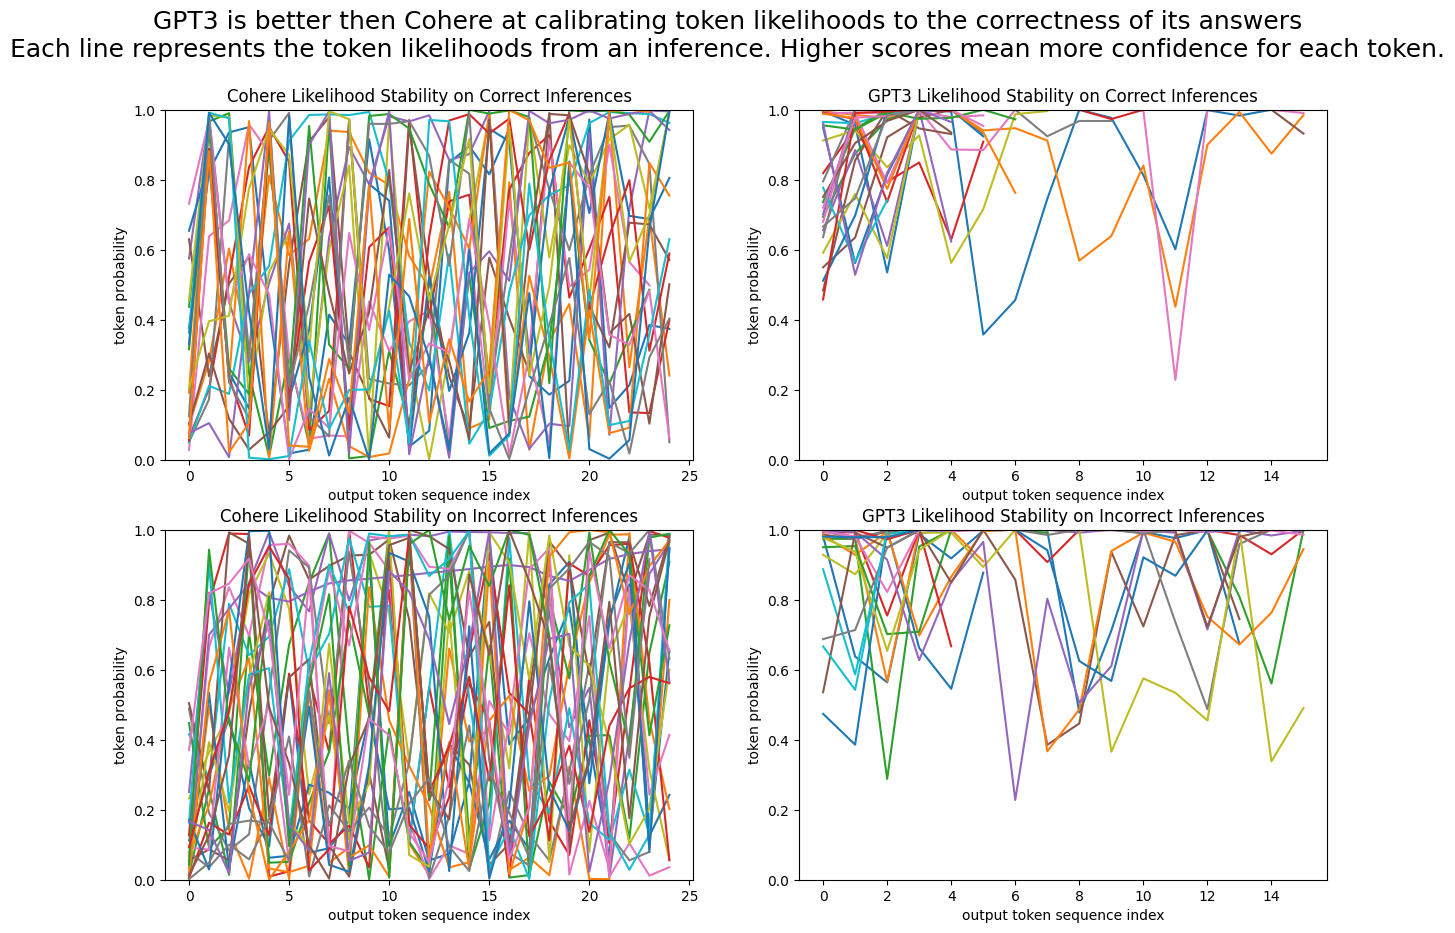

In [653]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

fig.suptitle('GPT3 is better then Cohere at calibrating token likelihoods to the correctness of its answers\
\nEach line represents the token likelihoods from an inference. Higher scores mean more confidence for each token.', fontsize=18)

for i in range(len(input_strings_inf)):
    
    if cohere_correct[i]:
        ax[0,0].plot(
            np.arange(len(cohere_likelihoods[i])), 
            np.array(cohere_likelihoods[i]), 
            label=cohere_query_result[i]['inference_id'])
    else:
        ax[1,0].plot(
            np.arange(len(cohere_likelihoods[i])), 
            np.array(cohere_likelihoods[i]), 
            label=cohere_query_result[i]['inference_id'])
        
    if gpt3_correct[i]:
        ax[0,1].plot(
            np.arange(len(gpt3_likelihoods[i])), 
            np.array(gpt3_likelihoods[i]), 
            label=gpt3_query_result[0]['inference_id'])
    else:
        ax[1,1].plot(
            np.arange(len(gpt3_likelihoods[i])), 
            np.array(gpt3_likelihoods[i]), 
            label=gpt3_query_result[0]['inference_id'])

ax[0,0].set_title('Cohere Likelihood Stability on Correct Inferences')
ax[0,0].set_xlabel('output token sequence index')
ax[0,0].set_ylabel('token probability')
ax[0,0].set_ylim([0,1])

ax[0,1].set_title('GPT3 Likelihood Stability on Correct Inferences')
ax[0,1].set_xlabel('output token sequence index')
ax[0,1].set_ylabel('token probability')
ax[0,1].set_ylim([0,1])

ax[1,0].set_title('Cohere Likelihood Stability on Incorrect Inferences')
ax[1,0].set_xlabel('output token sequence index')
ax[1,0].set_ylabel('token probability')
ax[1,0].set_ylim([0,1])

ax[1,1].set_title('GPT3 Likelihood Stability on Incorrect Inferences')
ax[1,1].set_xlabel('output token sequence index')
ax[1,1].set_ylabel('token probability')
ax[1,1].set_ylim([0,1])

plt.show()

# How does user feedback vary by model?

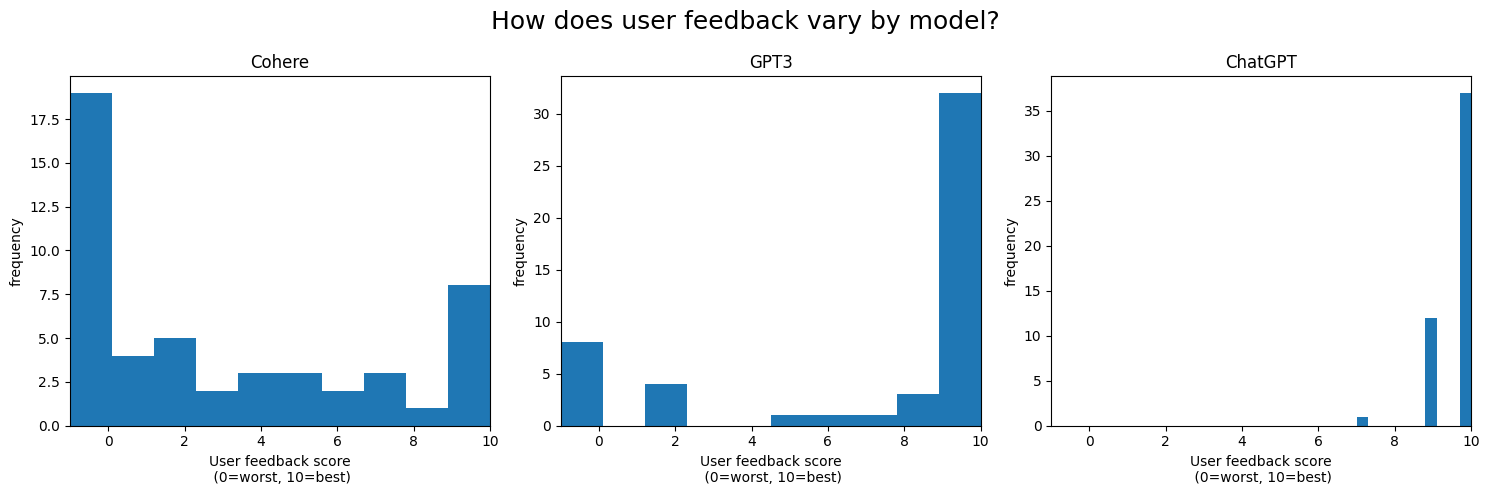

In [650]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

fig.suptitle('How does user feedback vary by model?', fontsize=18)

ax[0].hist(cohere_user_feedback_score)
ax[1].hist(gpt3_user_feedback_score)
ax[2].hist(chatgpt_user_feedback_score)
ax[0].set_title('Cohere')
ax[1].set_title('GPT3')
ax[2].set_title('ChatGPT')
for i in range(3):
    ax[i].set_xlim([-1,10])
    ax[i].set_xlabel('User feedback score\n (0=worst, 10=best)')
    ax[i].set_ylabel('frequency')
plt.tight_layout()
plt.show()

# How does response readability vary by model?

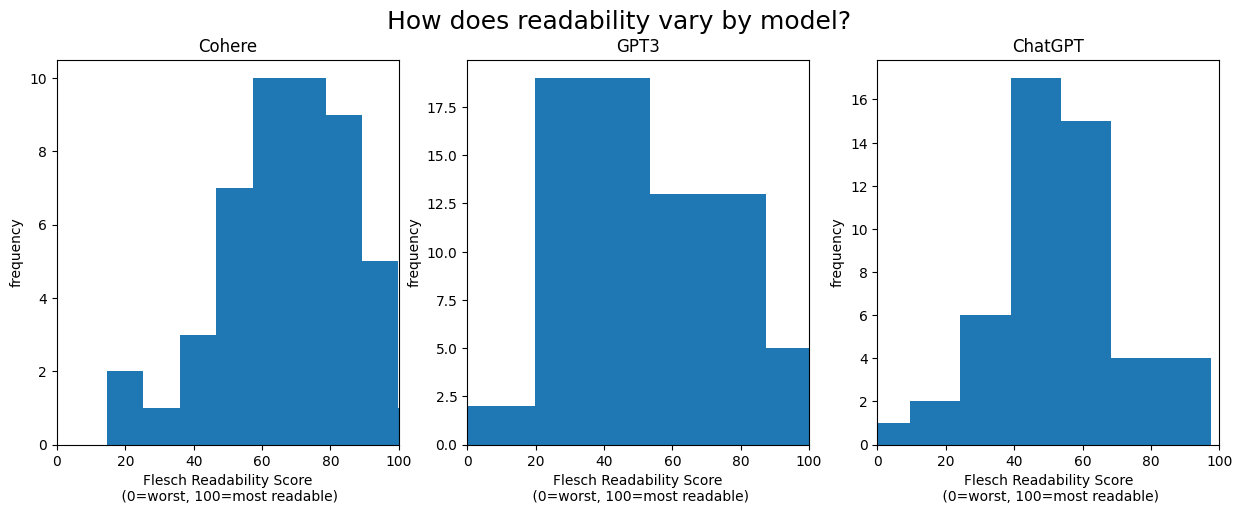

In [651]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

fig.suptitle('How does readability vary by model?', fontsize=18)

ax[0].hist(cohere_readability)
ax[1].hist(gpt3_readability)
ax[2].hist(chatgpt_readability)
ax[0].set_title('Cohere')
ax[1].set_title('GPT3')
ax[2].set_title('ChatGPT')
for i in range(3):
    ax[i].set_xlim([0,100])
    ax[i].set_xlabel('Flesch Readability Score\n (0=worst, 100=most readable)')
    ax[i].set_ylabel('frequency')
plt.show()

# What is driving the trends in user feedback?

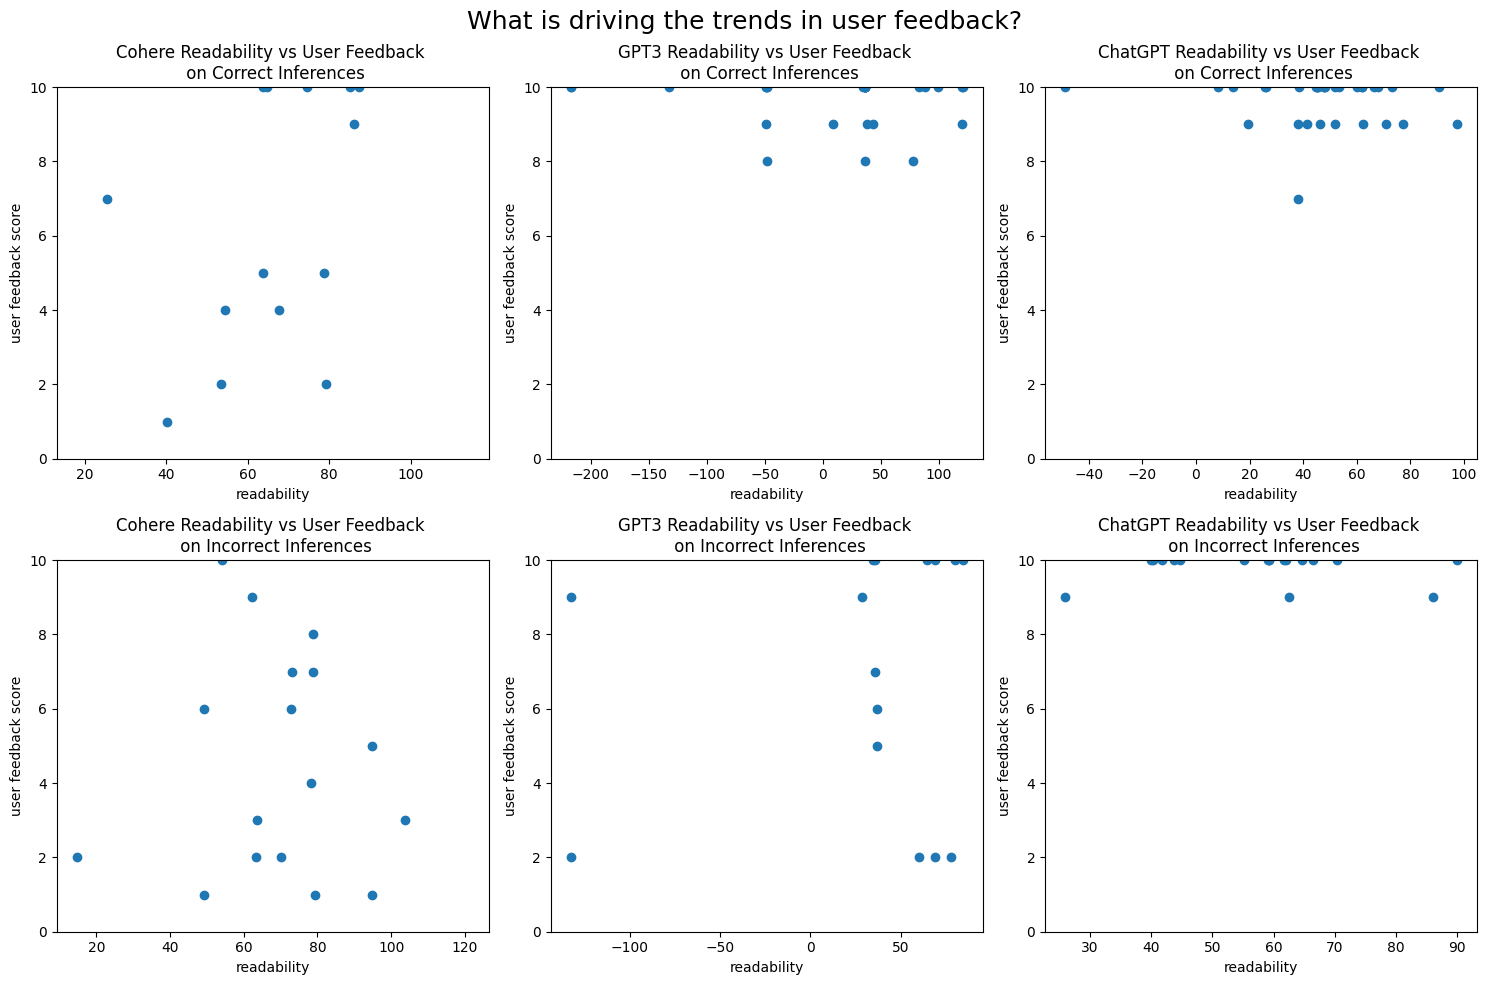

In [655]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))

fig.suptitle('What is driving the trends in user feedback?', fontsize=18)

cohere_correct_idx = [i for i in range(len(input_strings_inf)) if cohere_correct[i] ]
cohere_incorrect_idx = [i for i in range(len(input_strings_inf)) if not cohere_correct[i]]

gpt3_correct_idx = [i for i in range(len(input_strings_inf)) if gpt3_correct[i] ]
gpt3_incorrect_idx = [i for i in range(len(input_strings_inf)) if not gpt3_correct[i]]

chatgpt_correct_idx = [i for i in range(len(input_strings_inf)) if chatgpt_correct[i] ]
chatgpt_incorrect_idx = [i for i in range(len(input_strings_inf)) if not chatgpt_correct[i]]


cohere_readability_correct = [cohere_readability[i] for i in cohere_correct_idx]
cohere_feedback_correct = [cohere_user_feedback_score[i] for i in cohere_correct_idx]
cohere_readability_incorrect = [cohere_readability[i] for i in cohere_incorrect_idx]
cohere_feedback_incorrect = [cohere_user_feedback_score[i] for i in cohere_incorrect_idx]

gpt3_readability_correct = [gpt3_readability[i] for i in gpt3_correct_idx]
gpt3_feedback_correct = [gpt3_user_feedback_score[i] for i in gpt3_correct_idx]
gpt3_readability_incorrect = [gpt3_readability[i] for i in gpt3_incorrect_idx]
gpt3_feedback_incorrect = [gpt3_user_feedback_score[i] for i in gpt3_incorrect_idx]

chatgpt_readability_correct = [chatgpt_readability[i] for i in chatgpt_correct_idx]
chatgpt_feedback_correct = [chatgpt_user_feedback_score[i] for i in chatgpt_correct_idx]
chatgpt_readability_incorrect = [chatgpt_readability[i] for i in chatgpt_incorrect_idx]
chatgpt_feedback_incorrect = [chatgpt_user_feedback_score[i] for i in chatgpt_incorrect_idx]

ax[0,0].scatter(cohere_readability_correct, cohere_feedback_correct)
ax[0,1].scatter(gpt3_readability_correct, gpt3_feedback_correct)
ax[0,2].scatter(chatgpt_readability_correct, chatgpt_feedback_correct)
ax[1,0].scatter(cohere_readability_incorrect, cohere_feedback_incorrect)
ax[1,1].scatter(gpt3_readability_incorrect, gpt3_feedback_incorrect)
ax[1,2].scatter(chatgpt_readability_incorrect, chatgpt_feedback_incorrect)
        
ax[0,0].set_title('Cohere Readability vs User Feedback \n on Correct Inferences')
ax[0,0].set_xlabel('readability')
ax[0,0].set_ylabel('user feedback score')
ax[0,0].set_ylim([0,10])

ax[0,1].set_title('GPT3 Readability vs User Feedback \n on Correct Inferences')
ax[0,1].set_xlabel('readability')
ax[0,1].set_ylabel('user feedback score')
ax[0,1].set_ylim([0,10])

ax[0,2].set_title('ChatGPT Readability vs User Feedback \n on Correct Inferences')
ax[0,2].set_xlabel('readability')
ax[0,2].set_ylabel('user feedback score')
ax[0,2].set_ylim([0,10])

ax[1,0].set_title('Cohere Readability vs User Feedback \n on Incorrect Inferences')
ax[1,0].set_xlabel('readability')
ax[1,0].set_ylabel('user feedback score')
ax[1,0].set_ylim([0,10])

ax[1,1].set_title('GPT3 Readability vs User Feedback \n on Incorrect Inferences')
ax[1,1].set_xlabel('readability')
ax[1,1].set_ylabel('user feedback score')
ax[1,1].set_ylim([0,10])

ax[1,2].set_title('ChatGPT Readability vs User Feedback \n on Incorrect Inferences')
ax[1,2].set_xlabel('readability')
ax[1,2].set_ylabel('user feedback score')
ax[1,2].set_ylim([0,10])

plt.tight_layout()
plt.show()